# Adding functional information to protein clusters

So we'd like to figure out what these families of proteins are.
And more importantly we'd like to find some clusters of effector proteins.
So we'll fetch all of the interproscan and predector data and pick out what's interesting.
Later on we can do some enrichment analysis.

In [85]:
import xml.etree.ElementTree as ET
from typing import NamedTuple

from collections import Counter

import pandas as pd
import numpy as np
from Bio import SeqIO
from matplotlib import pyplot as plt
import pytaxonkit

import igraph as ig

In [2]:
def fmap(func, optional):
    if optional is None:
        return None
    else:
        return func(optional)

So the first thing we'll do is extract the uniprot data we have for these accessions.

In [3]:
entries = pd.read_csv("work/uniprot_entries.tsv", sep="\t")
entries.head()

,accession,orf,taxid,lineage,full_name,checksum,seq
0,A0A1D9PWC4,sscle_02g017740,665079,Eukaryota|Fungi|Dikarya|Ascomycota|Pezizomycot...,Sulfate adenylyltransferase,DD1F70C6BE0D9B8F,MANSPHGGVLKDLLARDLPRHNELSAEAETLPAIVLTERQLCDLEL...
1,A0A1D9Q7R8,sscle_07g057350,665079,Eukaryota|Fungi|Dikarya|Ascomycota|Pezizomycot...,ATP-dependent DNA helicase PIF1,837D7126F6FE4B3F,MPFGCTTSPALSSLIRGRLAQRWRAHPRFTFRITNVPTRSVLYSSI...
2,A0A1D9QCG4,sscle_09g074140,665079,Eukaryota|Fungi|Dikarya|Ascomycota|Pezizomycot...,E3 ubiquitin-protein ligase,7D2E7175B5AD853C,MASNSRVDSSLPAQPNLRLTIIAADGLYKRDVFRFPDPFAVATLSG...
3,A0A1D9QLW8,sscle_15g103530,665079,Eukaryota|Fungi|Dikarya|Ascomycota|Pezizomycot...,Pentafunctional AROM polypeptide,A24C113D2705D768,MGSTTFENPTRIEILGKEDIIVDFDIWRNFVAEDLLSDLPSSTYVL...
4,A0A384J5D0,BCIN_01g04340,332648,Eukaryota|Fungi|Dikarya|Ascomycota|Pezizomycot...,Sulfate adenylyltransferase,80E63CB177D83D54,MANSPHGGVLKDLLARDLSRHNELATEAETLPAVVLSERQLCDLEL...


## Finding sclerotinia sequences in the alphafold sequences.

I've found that not all proteins in our sclerotinia genome are represented in the uniprot data.
This is probably because some proteins weren't submitted to the NCBI or maybe the ORF names just aren't updated there.
I'll find the best matches using a quick sequence search.

In [4]:
tidied_alphafold_seqs = []

for seq in SeqIO.parse("work/all_alphafold_seqs.fasta", "fasta"):
    if len(seq.seq) == 0:
        continue

    seq.description = ""
    tidied_alphafold_seqs.append(seq)

SeqIO.write(tidied_alphafold_seqs, "work/all_alphafold_seqs.fasta", "fasta")

228612

In [5]:
all_accessions = pd.read_csv("output/clusters.tsv", sep="\t")["id"]

In [6]:
seqmatches = pd.read_csv("work/sclerotinia_alphafold_seqmatches.tsv", sep = "\t")
seqmatches = (
    seqmatches
    [(seqmatches["evalue"] < 1e-3) & (seqmatches["qcov"] > 0.7) & (seqmatches["tcov"] > 0.7) & (seqmatches["fident"] > 0.6) & seqmatches["target"].isin(all_accessions)]
    .sort_values(["query", "bits"], ascending=False)
)

seqmatches = pd.merge(
    seqmatches,
    entries["accession lineage orf".split()].rename(columns={"accession": "target"})
)

seqmatches["lineage"] = seqmatches["lineage"].str.replace("Eukaryota|Fungi|Dikarya|Ascomycota|Pezizomycotina|Leotiomycetes|Helotiales|Sclerotiniaceae|", "")
seqmatches_exact = (
    seqmatches
    [seqmatches["orf"] == seqmatches["query"]]
    .groupby("query")
    .first()
    .reset_index()
)

seqmatches_orf = (
    seqmatches
    [~seqmatches["query"].isin(seqmatches_exact["query"]) & (seqmatches["orf"].str[:len("sscle_")] == "sscle_") ]
    .groupby("query")
    .first()
    .reset_index()
)

seqmatches_sclero = (
    seqmatches
    [~seqmatches["query"].isin(np.union1d(seqmatches_exact["query"].values, seqmatches_orf["query"].values)) & (seqmatches["lineage"].str[:len("Sclerotinia|Sclerotinia sclerotiorum")] == "Sclerotinia|Sclerotinia sclerotiorum")]
    .groupby("query")
    .first()
    .reset_index()
)

seqmatches_best = (
    seqmatches[~seqmatches["query"].isin(np.union1d(seqmatches_exact["query"].values, np.union1d(seqmatches_orf["query"].values, seqmatches_sclero["query"].values)))]
    .groupby("query")
    .first()
    .reset_index()
)

print(seqmatches_exact.shape)
print(seqmatches_orf.shape)
print(seqmatches_sclero.shape)
print(seqmatches_best.shape)
seqmatches = pd.concat([seqmatches_exact, seqmatches_orf, seqmatches_sclero, seqmatches_best], axis=0)

seqmatches = seqmatches.sort_values("query")

seqmatches["pid_qcov_tcov"] = (seqmatches[["fident", "qcov", "tcov"]] * 100).round().astype(int).apply(lambda x: "|".join(map(str, x)), axis = 1)
seqmatches.to_csv("work/seqmatches_snapshot.tsv", sep="\t", index=False)

seqmatches_best.head()

(8519, 20)
(41, 20)
(143, 20)
(304, 20)


,query,target,pident,fident,nident,evalue,bits,qstart,qend,qlen,tstart,tend,tlen,alnlen,qheader,theader,qcov,tcov,lineage,orf
0,sscle_01g000370,A0A4S8QTT0,76.7,0.767,0,9.904000e-103,332,1,215,225,1,215,233,215,sscle_01g000370 [Sclerotinia sclerotiorum 1980...,A0A4S8QTT0,0.956,0.923,Botrytis|Botrytis galanthina,BGAL_0291g00150
1,sscle_01g001410,A0A4Z1HDI8,82.6,0.826,0,0.000000e+00,1708,1,1082,1087,1,1083,1086,1083,sscle_01g001410 [Sclerotinia sclerotiorum 1980...,A0A4Z1HDI8,0.995,0.997,Botryotinia|Botryotinia convoluta,BCON_0306g00060
2,sscle_01g001530,A0A4S8QNJ7,68.8,0.688,0,2.139000e-46,163,1,114,116,1,122,124,122,sscle_01g001530 [Sclerotinia sclerotiorum 1980...,A0A4S8QNJ7,0.983,0.984,Botrytis|Botrytis galanthina,BGAL_0468g00100
3,sscle_01g001800,M7TZ79,67.3,0.673,0,1.277000e-23,97,1,98,108,1,98,115,98,sscle_01g001800 [Sclerotinia sclerotiorum 1980...,M7TZ79,0.907,0.852,Botrytis|Botryotinia fuckeliana (strain BcDW1),BcDW1_4756
4,sscle_01g001810,A0A5M9K0A3,92.9,0.929,0,1.439000e-244,752,1,409,413,1,410,410,410,sscle_01g001810 [Sclerotinia sclerotiorum 1980...,A0A5M9K0A3,0.990,1.000,Monilinia|Monilinia fructicola,EYC84_005422


In [7]:
seqmatches = pd.read_csv("work/seqmatches_snapshot.tsv", sep="\t")
seqmatches[["fident", "evalue", "bits", "qcov", "tcov"]].describe()

,fident,evalue,bits,qcov,tcov
count,9007.000000,9.007000e+03,9007.000000,9007.000000,9007.000000
mean,0.991332,1.722460e-24,926.623626,0.997925,0.998378
std,0.047264,1.633209e-22,511.166151,0.019196,0.016792
min,0.601000,0.000000e+00,88.000000,0.704000,0.701000
25%,1.000000,0.000000e+00,550.000000,1.000000,1.000000
50%,1.000000,9.894000e-274,836.000000,1.000000,1.000000
75%,1.000000,2.262000e-177,1188.000000,1.000000,1.000000
max,1.000000,1.550000e-20,4349.000000,1.000000,1.000000


So you see that all of the matches are high quality.

There are a few sequences in our sclerotinia proteome that aren't in uniprot.
In these cases we've taken the best hit from elsewhere, which are also good matches.

## Tidying up our clusters

In [8]:
clusters = pd.read_csv("output/clusters_with_ips.tsv", sep="\t", na_values="-")
print(clusters.shape)
clusters.head()

(160510, 10)


,component,nmembers_component,cluster,nmembers_cluster,accession,orf,taxid,lineage,full_name,checksum
0,A0A4Z1EVR2,1609,A0A4Z1I887,938,A7F986,SS1G_14167,665079.0,Sclerotinia|Sclerotinia sclerotiorum (strain A...,Integral membrane protein,AB4A6EC16ABDD80F
1,A0A4Z1EVR2,1609,A0A4Z1I887,938,A7F6Y0,SS1G_13360,665079.0,Sclerotinia|Sclerotinia sclerotiorum (strain A...,Integral membrane protein,4DCE17C477F58154
2,A0A4Z1EVR2,1609,A0A4Z1I887,938,A7F6H1,SS1G_13200,665079.0,Sclerotinia|Sclerotinia sclerotiorum (strain A...,NaN,4AA7E08CEBA56A2D
3,A0A4Z1EVR2,1609,A0A4Z1I887,938,A7F674,SS1G_13103,665079.0,Sclerotinia|Sclerotinia sclerotiorum (strain A...,Integral membrane protein,87E4D1053EFD4F06
4,A0A4Z1EVR2,1609,A0A4Z1I887,938,A7F5N0,SS1G_12908,665079.0,Sclerotinia|Sclerotinia sclerotiorum (strain A...,Integral membrane protein,27E92CFCBE7FFBFC


In [55]:
print(
    "N seqs           :", clusters["checksum"].nunique(),
    "\nN accession      :", clusters["accession"].nunique(),
    "\nN clusters       :", clusters["cluster"].nunique(),
    "\nN components     :", clusters["component"].nunique(),
    "\nN clusters > 1   :", clusters.loc[clusters["nmembers_cluster"] > 1, "cluster"].nunique(),
    "\nN clusters > 5   :", clusters.loc[clusters["nmembers_cluster"] > 5, "cluster"].nunique(),
    "\nN clusters > 10  :", clusters.loc[clusters["nmembers_cluster"] > 10, "cluster"].nunique(),
    "\nN clusters > 50  :", clusters.loc[clusters["nmembers_cluster"] > 50, "cluster"].nunique(),
    "\nN clusters > 100 :", clusters.loc[clusters["nmembers_cluster"] > 100, "cluster"].nunique(),
    "\nN clusters > 500 :", clusters.loc[clusters["nmembers_cluster"] > 500, "cluster"].nunique(),
    "\nN clusters > 1000:", clusters.loc[clusters["nmembers_cluster"] > 1000, "cluster"].nunique()
)

N seqs           : 142480 
N accession      : 160510 
N clusters       : 13126 
N components     : 8314 
N clusters > 1   : 13126 
N clusters > 5   : 6287 
N clusters > 10  : 5129 
N clusters > 50  : 361 
N clusters > 100 : 118 
N clusters > 500 : 9 
N clusters > 1000: 0


## Fetching taxonomic information

I would like to know the taxonomic composition of the clusters.
All families should be under the sclerotiniaceae, but it would be helpful to know if any are restricted to a particular genus or species.

This takes a while and uses lots of memory, so again we'll snapshot it.

In [9]:
lcas = pd.read_csv("work/lca_snapshot1.tsv", sep="\t", na_values="-")
print(lcas.shape)
lcas.head()

(13126, 3)


,cluster,lca_taxid,lca_name
0,A0A023NBE9,28983,Sclerotiniaceae
1,A0A088CAF2,28983,Sclerotiniaceae
2,A0A088CAP5,28983,Sclerotiniaceae
3,A0A088CAV4,28983,Sclerotiniaceae
4,A0A088CAV5,5179,Sclerotinia


In [10]:
clusters_lca = pd.merge(
    clusters,
    lcas,
    on="cluster",
    how="left"
)

tmp = (
    seqmatches
    .rename(columns={"query": "best_hit", "target": "accession"})
)

tmp["best_hit_pid_qcov_tcov"] = tmp.apply(lambda x: f"{x['pident'] / 100:.2f}_{x['qcov']:.2f}_{x['tcov']:.2f}", axis=1)

clusters_best_matches = pd.merge(
    clusters_lca,
    tmp["accession best_hit best_hit_pid_qcov_tcov".split()],
    on="accession",
    how="left"
)

clusters_best_matches.head()

,component,nmembers_component,cluster,nmembers_cluster,accession,orf,taxid,lineage,full_name,checksum,lca_taxid,lca_name,best_hit,best_hit_pid_qcov_tcov
0,A0A4Z1EVR2,1609,A0A4Z1I887,938,A7F986,SS1G_14167,665079.0,Sclerotinia|Sclerotinia sclerotiorum (strain A...,Integral membrane protein,AB4A6EC16ABDD80F,28983,Sclerotiniaceae,NaN,NaN
1,A0A4Z1EVR2,1609,A0A4Z1I887,938,A7F6Y0,SS1G_13360,665079.0,Sclerotinia|Sclerotinia sclerotiorum (strain A...,Integral membrane protein,4DCE17C477F58154,28983,Sclerotiniaceae,NaN,NaN
2,A0A4Z1EVR2,1609,A0A4Z1I887,938,A7F6H1,SS1G_13200,665079.0,Sclerotinia|Sclerotinia sclerotiorum (strain A...,NaN,4AA7E08CEBA56A2D,28983,Sclerotiniaceae,NaN,NaN
3,A0A4Z1EVR2,1609,A0A4Z1I887,938,A7F674,SS1G_13103,665079.0,Sclerotinia|Sclerotinia sclerotiorum (strain A...,Integral membrane protein,87E4D1053EFD4F06,28983,Sclerotiniaceae,NaN,NaN
4,A0A4Z1EVR2,1609,A0A4Z1I887,938,A7F5N0,SS1G_12908,665079.0,Sclerotinia|Sclerotinia sclerotiorum (strain A...,Integral membrane protein,27E92CFCBE7FFBFC,28983,Sclerotiniaceae,NaN,NaN


Next I'd like to fetch effector information we have about our Sclerotinia proteins.

In [11]:
effector_homologues = pd.read_csv("output/predector_protein/effectordb_matches.tsv", sep="\t", na_values=".")
effector_homologues = effector_homologues["gene_name effector_name".split()].drop_duplicates().groupby("gene_name")["effector_name"].apply(lambda x: "|".join(x)).to_dict()

funcs = pd.read_csv("output/protein_functional_annotation_wide.tsv", sep="\t", na_values=".")
funcs["effector_name"] = funcs["name"].apply(effector_homologues.get)
funcs = funcs[["name", "effector_name"] + [n for n in funcs.columns if n not in ("name", "effector_name")]]

funcs["signal_peptide"] = (funcs[['signalp3_nn', 'signalp3_hmm', 'signalp4', 'signalp5', 'signalp6', 'deepsig', 'targetp_secreted', 'tmbed_sp']] > 0.5).any(axis=1)
tmp = funcs.loc[:, ["tmhmm_tmcount", "phobius_tmcount", "tmbed_domains"]]
tmp["tmbed_domains"] = tmp["tmbed_domains"].str.count(",").fillna(0)

funcs["single_transmembrane"] = (tmp > 0).any(axis=1) & (tmp <= 1).all(axis=1)
funcs["multi_transmembrane"] = (tmp > 1).any(axis=1)

del tmp

funcs["deeploc_extracellular"] = (funcs[["deeploc_extracellular", "deeploc2_extracellular"]] > 0.5).any(axis=1)
funcs["deeploc_golgi_er"] = (funcs[["deeploc_golgi", "deeploc_endoplasmic_reticulum"]] > 0.5).any(axis=1) | (funcs[["deeploc2_golgi", "deeploc2_endoplasmic_reticulum"]] > 0.5).any(axis=1)
funcs["deeploc_cell_membrane"] = (funcs["deeploc_cell_membrane"] > 0.5) | (funcs["deeploc2_cell_membrane"] > 0.5)
funcs["secreted"] = funcs["signal_peptide"] & (~funcs["multi_transmembrane"]) & funcs["deeploc_extracellular"]
funcs["effector"] = (
    ((funcs["effector_score"] > 1) & (~funcs["deeploc_golgi_er"])) |
    (funcs["secreted"] & (funcs[["effectorp1", "effectorp2", "effectorp3_cytoplasmic", "effectorp3_apoplastic"]] > 0.5).any(axis=1))
)

funcs = funcs[[
    'name',
    'effector_score',
    "secreted",
    "effector",
    'effector_name',
    'phibase_genes',
    'swissprot_protein_name', 'swissprot_gene_name',
    'pdb_protein_name', 
    'go_names',
    'ipr_name',
    'dbcan_description',
    'residue_number',
    'effectorp1', 'effectorp2', 'effectorp3_cytoplasmic', 'effectorp3_apoplastic',
    'deepredeff_fungi', 'deepredeff_oomycete',
    'apoplastp',
    'signal_peptide', 'deeploc_extracellular', 'deeploc_golgi_er',
    'deeploc_cell_membrane',
    'single_transmembrane', 'multi_transmembrane',   
]]

funcs.head()

,name,effector_score,secreted,effector,effector_name,phibase_genes,swissprot_protein_name,swissprot_gene_name,pdb_protein_name,go_names,...,effectorp3_apoplastic,deepredeff_fungi,deepredeff_oomycete,apoplastp,signal_peptide,deeploc_extracellular,deeploc_golgi_er,deeploc_cell_membrane,single_transmembrane,multi_transmembrane
0,sscle_03g031910,3.816,True,True,None,NaN,NaN,NaN,NaN,NaN,...,0.807,0.608,0.670,0.42,True,True,False,False,False,False
1,sscle_16g107730,3.816,True,True,None,NaN,NaN,NaN,NaN,NaN,...,0.795,0.608,0.669,0.42,True,True,False,False,False,False
2,sscle_09g074030,3.263,True,True,None,NaN,NaN,NaN,NaN,NaN,...,0.803,0.513,0.669,0.59,True,True,False,False,False,False
3,sscle_05g045060,3.234,True,True,SsINE5|BcSSP2,NaN,NaN,NaN,NaN,NaN,...,0.870,0.204,0.374,0.89,True,True,False,False,False,False
4,sscle_01g003850,3.056,True,True,SsSSVP1,NaN,NaN,NaN,NaN,NaN,...,0.786,0.283,0.241,0.62,True,True,False,False,False,False


In [12]:
#seqs = SeqIO.to_dict(SeqIO.parse("work/Sscl1980.faa", "fasta"))
sclero_clusters = clusters_best_matches.loc[~pd.isna(clusters_best_matches["best_hit"]), ]

sclero_clusters = pd.merge(
    sclero_clusters.groupby("cluster")["accession"].nunique().reset_index().rename(columns={"accession": "nsclero_members"}),
    sclero_clusters,
    on="cluster"
)

def mapper(s):    
    counter = Counter(s.str.split("|").str[-1])
    return "|".join([f"{k} (n={v})" for k, v in counter.items()])

sclero_clusters = pd.merge(
    sclero_clusters,
    clusters.groupby("cluster")["lineage"].apply(mapper).reset_index().rename(columns={"lineage": "nmembers_other_taxa"}),
    on="cluster"
)


sclero_clusters = sclero_clusters[['cluster', 'nmembers_cluster', 'nsclero_members', 'nmembers_other_taxa', 'accession', 'orf', 'best_hit', 'best_hit_pid_qcov_tcov', 'taxid', 'lineage', 'full_name']]

sclero_clusters = pd.merge(
    sclero_clusters,
    funcs,
    left_on="best_hit",
    right_on="name",
    how="left"
)

sclero_clusters.to_csv("output/foldseek_clusters_sclero.tsv", sep="\t", na_rep="-", index=False)

In [13]:
sclero_clusters = pd.read_csv("output/foldseek_clusters_sclero.tsv", sep="\t", na_values="-")
print(sclero_clusters.shape)
sclero_clusters.head()

(9007, 37)


,cluster,nmembers_cluster,nsclero_members,nmembers_other_taxa,accession,orf,best_hit,best_hit_pid_qcov_tcov,taxid,lineage,...,effectorp3_apoplastic,deepredeff_fungi,deepredeff_oomycete,apoplastp,signal_peptide,deeploc_extracellular,deeploc_golgi_er,deeploc_cell_membrane,single_transmembrane,multi_transmembrane
0,A0A088FQ56,526,28,Sclerotinia sclerotiorum (strain ATCC 18683 / ...,A0A1D9QMG5,sscle_16g108960,sscle_16g108960,1.00_1.00_1.00,665079.0,Sclerotinia|Sclerotinia sclerotiorum (strain A...,...,NaN,0.060,0.397,0.13,False,False,True,True,False,True
1,A0A088FQ56,526,28,Sclerotinia sclerotiorum (strain ATCC 18683 / ...,A0A1D9QH45,sscle_12g090240,sscle_12g090240,1.00_1.00_1.00,665079.0,Sclerotinia|Sclerotinia sclerotiorum (strain A...,...,NaN,0.333,0.460,0.04,False,False,True,True,False,True
2,A0A088FQ56,526,28,Sclerotinia sclerotiorum (strain ATCC 18683 / ...,A0A1D9QGA9,sscle_11g086120,sscle_11g086120,1.00_1.00_1.00,665079.0,Sclerotinia|Sclerotinia sclerotiorum (strain A...,...,NaN,0.963,0.453,0.21,False,False,True,False,False,True
3,A0A088FQ56,526,28,Sclerotinia sclerotiorum (strain ATCC 18683 / ...,A0A1D9QE24,sscle_10g079570,sscle_10g079570,1.00_1.00_1.00,665079.0,Sclerotinia|Sclerotinia sclerotiorum (strain A...,...,NaN,0.764,0.463,0.04,False,False,True,True,False,True
4,A0A088FQ56,526,28,Sclerotinia sclerotiorum (strain ATCC 18683 / ...,A0A1D9QDR7,sscle_10g078210,sscle_10g078210,1.00_1.00_1.00,665079.0,Sclerotinia|Sclerotinia sclerotiorum (strain A...,...,NaN,0.073,0.383,0.08,False,False,False,True,False,True


In [14]:
print(
    "N sclero clusters    :", sclero_clusters["cluster"].nunique(),
    "\nN sclero members     :", sclero_clusters["best_hit"].nunique(),
    "\nN sclero clusters > 1:", sclero_clusters.loc[sclero_clusters["nmembers_cluster"] > 1, "cluster"].nunique(),
    "\nN sclero secreted    :", sclero_clusters.loc[sclero_clusters["secreted"], "cluster"].nunique(),
    "\nN sclero effector    :", sclero_clusters.loc[sclero_clusters["effector"], "cluster"].nunique(),
)

N sclero clusters    : 6433 
N sclero members     : 9007 
N sclero clusters > 1: 6433 
N sclero secreted    : 448 
N sclero effector    : 216


In [18]:
cluster_counts = clusters.groupby("component")["accession"].nunique()
for i in [0, 5, 10, 50, 100, 500, 1000, 5000, 10000]:
    print(f"N >= {i} =", (cluster_counts > i).sum())

N >= 0 = 8314
N >= 5 = 4759
N >= 10 = 4080
N >= 50 = 372
N >= 100 = 144
N >= 500 = 23
N >= 1000 = 13
N >= 5000 = 1
N >= 10000 = 0


In [19]:
cluster_counts = clusters.groupby("cluster")["accession"].nunique()
for i in [0, 5, 10, 50, 100, 500, 1000]:
    print(f"N >= {i} =", (cluster_counts > i).sum())

N >= 0 = 13126
N >= 5 = 6287
N >= 10 = 5129
N >= 50 = 361
N >= 100 = 118
N >= 500 = 9
N >= 1000 = 0


In [47]:
cand_effectors = pd.read_csv("sclerotinia_candidate_effectors.tsv", sep="\t", na_values="-")
cand_effectors = (
    cand_effectors
    .loc[cand_effectors["candidate"].isin(["Effector", "MAYBE"]) | ~pd.isna(cand_effectors["published"]), ]
)
cand_effectors.head()

,name,published,candidate,effector_score,effectordb_name,phibase_genes,phibase_phenotypes,dbcan_accession,dbcan_description,swissprot_protein_name,...,deeploc2_preds,deeploc2_signals,signalp3_nn_d,signalp3_hmm_s,signalp4_d,signalp5_prob,signalp6_prob,deepsig_signal_prob,deepsig_transmembrane_prob,deepsig_other_prob
0,sscle_03g031910,NaN,Effector,3.82,NaN,NaN,NaN,NaN,NaN,NaN,...,Extracellular,Signal peptide,0.776,0.996,0.677,0.990,1.0,1.0,NaN,NaN
1,sscle_16g107730,NaN,Effector,3.82,NaN,NaN,NaN,NaN,NaN,NaN,...,Extracellular,Signal peptide,0.785,0.995,0.679,0.992,1.0,1.0,NaN,NaN
2,sscle_09g074030,NaN,Effector,3.26,NaN,NaN,NaN,NaN,NaN,NaN,...,Extracellular,Signal peptide,0.831,0.996,0.736,0.994,1.0,1.0,NaN,NaN
3,sscle_05g045060,Effector,Effector,3.23,SsINE5|BcSSP2,NaN,NaN,NaN,NaN,NaN,...,Extracellular,Signal peptide,0.871,0.999,0.874,1.000,1.0,1.0,NaN,NaN
4,sscle_01g003850,Effector,Effector,3.06,SsSSVP1,NaN,NaN,NaN,NaN,NaN,...,Extracellular,Signal peptide,0.812,1.000,0.781,0.999,1.0,1.0,NaN,NaN


In [50]:
cand_clusters = pd.read_csv("output/cand_clusters.tsv", sep="\t", na_values="-")
cand_clusters.head()

,best_hit,published,candidate,effectordb_name,cluster,nmembers_cluster,nsclero_members,nmembers_other_taxa,accession,orf,...,effectorp3_apoplastic,deepredeff_fungi,deepredeff_oomycete,apoplastp,signal_peptide,deeploc_extracellular,deeploc_golgi_er,deeploc_cell_membrane,single_transmembrane,multi_transmembrane
0,sscle_12g088720,Non Effector,CAZyme/CWDE,SSPG6|MoCDIP1,H6W9D7,316,12,Stromatinia cepivora (n=1)|Sclerotinia trifoli...,A0A1D9QH33,sscle_12g088720,...,0.564,0.971,0.465,0.94,True,True,False,False,False,False
1,sscle_05g040500,NaN,NaN,NaN,H6W9D7,316,12,Stromatinia cepivora (n=1)|Sclerotinia trifoli...,A0A1D9Q2U2,sscle_05g040500,...,0.529,0.932,0.324,0.88,True,True,False,False,False,False
2,sscle_04g035440,NaN,NaN,NaN,H6W9D7,316,12,Stromatinia cepivora (n=1)|Sclerotinia trifoli...,A0A1D9Q1H0,sscle_04g035440,...,0.551,0.959,0.544,0.86,True,True,False,False,False,False
3,sscle_10g078830,NaN,NaN,NaN,H6W9D7,316,12,Stromatinia cepivora (n=1)|Sclerotinia trifoli...,A0A1D9QES2,sscle_10g078830,...,0.638,0.802,0.597,0.84,True,True,False,False,False,False
4,sscle_02g018820,Non Effector,CAZyme/CWDE,PGa|SSPG5|MoCDIP1,H6W9D7,316,12,Stromatinia cepivora (n=1)|Sclerotinia trifoli...,A0A1D9PX25,sscle_02g018820,...,0.529,0.114,0.347,0.87,True,True,False,False,False,False


In [58]:
cand_clusters[cand_clusters["cluster"] == "A0A384JF26"]

,best_hit,published,candidate,effectordb_name,cluster,nmembers_cluster,nsclero_members,nmembers_other_taxa,accession,orf,...,effectorp3_apoplastic,deepredeff_fungi,deepredeff_oomycete,apoplastp,signal_peptide,deeploc_extracellular,deeploc_golgi_er,deeploc_cell_membrane,single_transmembrane,multi_transmembrane
53,sscle_16g107730,NaN,Effector,NaN,A0A384JF26,19,5,Sclerotinia sclerotiorum (strain ATCC 18683 / ...,A0A1D9QN57,sscle_16g107730,...,0.795,0.608,0.669,0.42,True,True,False,False,False,False
54,sscle_03g031910,NaN,Effector,NaN,A0A384JF26,19,5,Sclerotinia sclerotiorum (strain ATCC 18683 / ...,A0A1D9Q0F2,sscle_03g031910,...,0.807,0.608,0.670,0.42,True,True,False,False,False,False
55,sscle_09g074030,NaN,Effector,NaN,A0A384JF26,19,5,Sclerotinia sclerotiorum (strain ATCC 18683 / ...,A0A1D9QDE2,sscle_09g074030,...,0.803,0.513,0.669,0.59,True,True,False,False,False,False
56,sscle_13g097000,NaN,Effector,NaN,A0A384JF26,19,5,Sclerotinia sclerotiorum (strain ATCC 18683 / ...,A0A1D9QN49,sscle_16g111300,...,0.751,0.051,0.641,0.62,True,True,False,False,False,False
57,sscle_16g111300,NaN,Effector,NaN,A0A384JF26,19,5,Sclerotinia sclerotiorum (strain ATCC 18683 / ...,A0A1D9QN49,sscle_16g111300,...,0.751,0.051,0.641,0.62,True,True,False,False,False,False
58,sscle_06g055280,NaN,Effector,NaN,A0A384JF26,19,5,Sclerotinia sclerotiorum (strain ATCC 18683 / ...,A0A1D9QN49,sscle_16g111300,...,0.763,0.051,0.641,0.65,True,True,False,False,False,False
59,sscle_07g061960,NaN,Effector,NaN,A0A384JF26,19,5,Sclerotinia sclerotiorum (strain ATCC 18683 / ...,A0A1D9Q947,sscle_07g061960,...,0.763,0.051,0.641,0.65,True,True,False,False,False,False


In [80]:
def get_subgraph(graph, clusters_df, cluster_ids: list[int] = None, ids: list[str] = None):
    sg_ids = set()

    if cluster_ids is not None:
        sg_ids.update([
            NAME_TO_INDEX.get(i)
            for i
            in clusters.loc[clusters["cluster"].isin(cluster_ids), "accession"]
        ])

    if ids is not None:
        sg_ids.update([
            NAME_TO_INDEX.get(i)
            for i
            in ids
        ])

    return graph.subgraph(sg_ids)

In [65]:
G = ig.read("output/alphafold_graph.graphml", format="graphml")
NAME_TO_INDEX = {n: i for i, n in enumerate(G.vs["name"])}

In [ ]:
#A0A384JF26

In [89]:
Gsub = get_subgraph(G, cand_clusters, cluster_ids=["A0A4Y8CMI0"]) 

In [90]:
layout = Gsub.layout(layout='drl')

<Axes: >

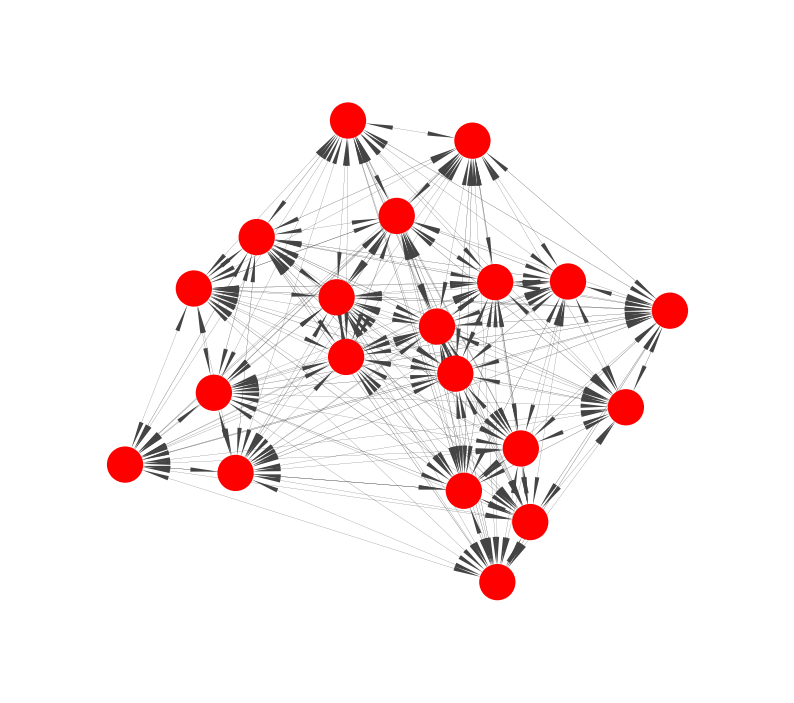

In [96]:
weights = [np.log((1 - x) + 1) * 5 for x in Gsub.es.get_attribute_values("tcov")]

fig, ax = plt.subplots(figsize=(10, 10))
ig.plot(
    Gsub,
    layout=layout,
    vertex_size=0.1,
    edge_width=weights,
    edge_arrow_width=0.25,
    edge_arrow_size=0.005,
    edge_vertex_frame_color=None,
    vertex_frame_width=0,
    target=ax,
    autocurve=False
)